# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [81]:
train_npz = np.load('./train.npz')
train_data = train_npz['data']
test_npz  = np.load('./test_input.npz')
test_data  = test_npz['data']

In [82]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [83]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [84]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

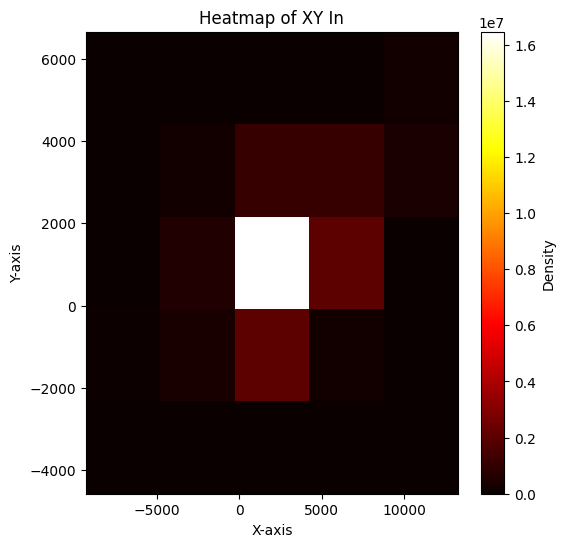

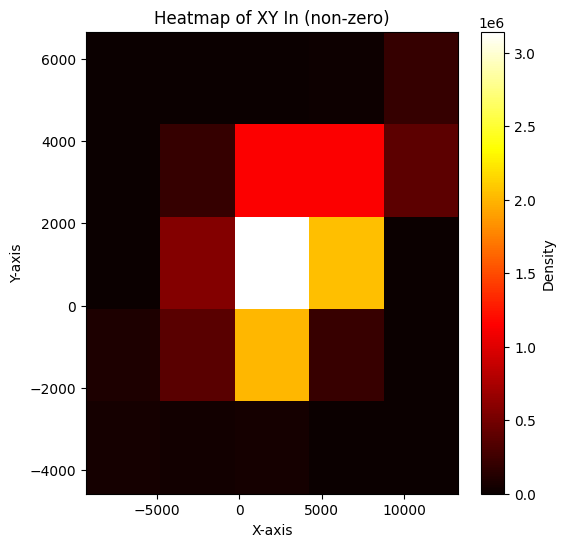

In [85]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

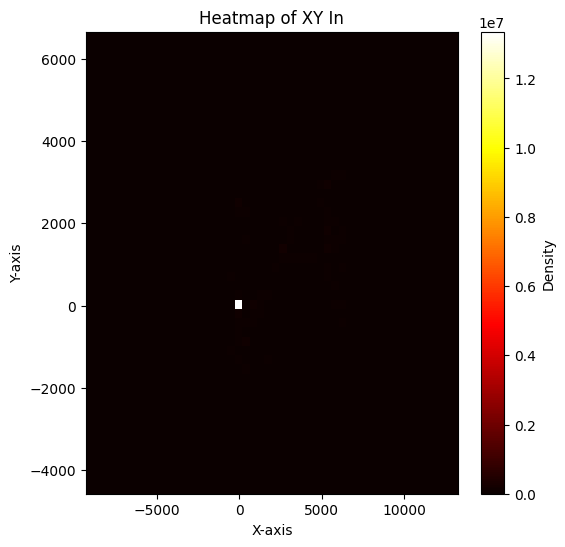

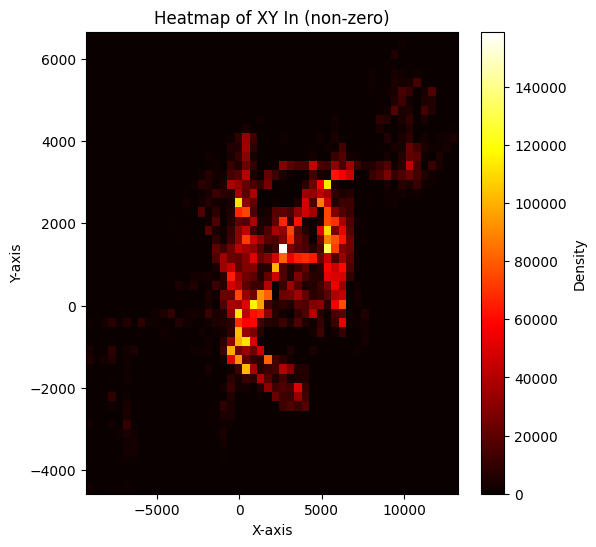

In [86]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [87]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [88]:
torch.manual_seed(251)
np.random.seed(42)

scale = 5.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


In [89]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=256, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InteractionAwareLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=256, output_dim=60*2, num_agents=50):
        super(InteractionAwareLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_agents = num_agents
        
        # Shared LSTM for processing all agents' trajectories
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Attention mechanism to combine agents' influences
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)
        
        # Final prediction layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # x2 for ego + context

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 6)
        
        lstm_out, _ = self.lstm(x)  # (B*N, 50, H)
        last_hidden = lstm_out[:, -1, :].view(x.shape[0] // 50, self.num_agents, self.hidden_dim)
        
        # Separate ego features and other agents
        ego_hidden = last_hidden[:, 0, :].unsqueeze(1)  # (B, 1, H)
        others_hidden = last_hidden[:, 1:, :]  # (B, N-1, H)
        
        context, _ = self.attention(
            ego_hidden, others_hidden, others_hidden,
            need_weights=False
        )
        
        # Combine ego features with context
        combined = torch.cat([ego_hidden.squeeze(1), context.squeeze(1)], dim=1)
        
        # Final prediction
        out = self.fc(combined)
        
        return out.view(-1, 60, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [ ]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
model = InteractionAwareLSTM().to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3)
early_stopping_patience = 15
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [92]:
for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    # scheduler.step()
    scheduler.step(val_loss)
    
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/c3/nf0b8q01303dvc7nr1m9s8fw0000gn/T/ipykernel_35618/3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/c3/nf0b8q01303dvc7nr1m9s8fw0000gn/T/ipykernel_35618/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|          | 1/100 [00:32<53:11, 32.24s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   4.2673 | val normalized MSE   1.4547, | val MAE   3.4004 | val MSE  36.3674


Epoch:   2%|▏         | 2/100 [00:59<47:44, 29.23s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   1.0608 | val normalized MSE   0.7906, | val MAE   2.4290 | val MSE  19.7660


Epoch:   3%|▎         | 3/100 [01:25<45:12, 27.96s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.7925 | val normalized MSE   0.8442, | val MAE   2.6538 | val MSE  21.1057


Epoch:   4%|▍         | 4/100 [01:52<43:41, 27.31s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.7270 | val normalized MSE   0.7334, | val MAE   2.3156 | val MSE  18.3351


Epoch:   5%|▌         | 5/100 [02:18<42:42, 26.97s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.6365 | val normalized MSE   0.5995, | val MAE   2.0814 | val MSE  14.9866


Epoch:   6%|▌         | 6/100 [02:44<41:41, 26.61s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.6062 | val normalized MSE   0.5870, | val MAE   2.0298 | val MSE  14.6757


Epoch:   7%|▋         | 7/100 [03:09<40:43, 26.28s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.5522 | val normalized MSE   0.5486, | val MAE   1.9346 | val MSE  13.7162


Epoch:   8%|▊         | 8/100 [03:36<40:28, 26.40s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.5472 | val normalized MSE   0.5142, | val MAE   1.8991 | val MSE  12.8544


Epoch:   9%|▉         | 9/100 [04:03<40:24, 26.65s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.5114 | val normalized MSE   0.4958, | val MAE   1.7771 | val MSE  12.3958


Epoch:  10%|█         | 10/100 [04:30<39:56, 26.63s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.4926 | val normalized MSE   0.4778, | val MAE   1.7865 | val MSE  11.9462


Epoch:  11%|█         | 11/100 [04:57<39:36, 26.70s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.4993 | val normalized MSE   0.5587, | val MAE   1.9569 | val MSE  13.9684


Epoch:  12%|█▏        | 12/100 [05:24<39:11, 26.72s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.4898 | val normalized MSE   0.4797, | val MAE   1.8012 | val MSE  11.9925


Epoch:  13%|█▎        | 13/100 [05:50<38:30, 26.56s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.4754 | val normalized MSE   0.4717, | val MAE   1.7747 | val MSE  11.7919


Epoch:  14%|█▍        | 14/100 [06:17<38:12, 26.65s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.4556 | val normalized MSE   0.4508, | val MAE   1.6528 | val MSE  11.2702


Epoch:  15%|█▌        | 15/100 [06:44<38:04, 26.87s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.4509 | val normalized MSE   0.4650, | val MAE   1.7558 | val MSE  11.6243


Epoch:  16%|█▌        | 16/100 [07:11<37:44, 26.95s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.4437 | val normalized MSE   0.4189, | val MAE   1.5812 | val MSE  10.4736


Epoch:  17%|█▋        | 17/100 [07:38<37:12, 26.89s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.4377 | val normalized MSE   0.4562, | val MAE   1.7181 | val MSE  11.4048


Epoch:  18%|█▊        | 18/100 [08:05<36:41, 26.84s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.4313 | val normalized MSE   0.4375, | val MAE   1.6285 | val MSE  10.9364


Epoch:  19%|█▉        | 19/100 [08:32<36:31, 27.05s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.4337 | val normalized MSE   0.4181, | val MAE   1.6789 | val MSE  10.4514


Epoch:  20%|██        | 20/100 [09:00<36:30, 27.38s/epoch]

Epoch 019 | Learning rate 0.001000 | train normalized MSE   0.4258 | val normalized MSE   0.4250, | val MAE   1.6872 | val MSE  10.6253


Epoch:  21%|██        | 21/100 [09:27<35:46, 27.17s/epoch]

Epoch 020 | Learning rate 0.001000 | train normalized MSE   0.4294 | val normalized MSE   0.4090, | val MAE   1.6210 | val MSE  10.2257


Epoch:  22%|██▏       | 22/100 [09:54<35:07, 27.02s/epoch]

Epoch 021 | Learning rate 0.001000 | train normalized MSE   0.4121 | val normalized MSE   0.4331, | val MAE   1.6855 | val MSE  10.8270


Epoch:  23%|██▎       | 23/100 [10:20<34:22, 26.78s/epoch]

Epoch 022 | Learning rate 0.001000 | train normalized MSE   0.4020 | val normalized MSE   0.4141, | val MAE   1.6542 | val MSE  10.3516


Epoch:  24%|██▍       | 24/100 [10:46<33:31, 26.47s/epoch]

Epoch 023 | Learning rate 0.001000 | train normalized MSE   0.3974 | val normalized MSE   0.4134, | val MAE   1.6324 | val MSE  10.3343


Epoch:  25%|██▌       | 25/100 [11:12<33:01, 26.42s/epoch]

Epoch 024 | Learning rate 0.000800 | train normalized MSE   0.4025 | val normalized MSE   0.4314, | val MAE   1.7121 | val MSE  10.7851


Epoch:  26%|██▌       | 26/100 [11:40<33:10, 26.90s/epoch]

Epoch 025 | Learning rate 0.000800 | train normalized MSE   0.3886 | val normalized MSE   0.3969, | val MAE   1.5770 | val MSE   9.9214


Epoch:  27%|██▋       | 27/100 [12:07<32:57, 27.09s/epoch]

Epoch 026 | Learning rate 0.000800 | train normalized MSE   0.3782 | val normalized MSE   0.4019, | val MAE   1.5718 | val MSE  10.0475


Epoch:  28%|██▊       | 28/100 [12:35<32:36, 27.18s/epoch]

Epoch 027 | Learning rate 0.000800 | train normalized MSE   0.3857 | val normalized MSE   0.3905, | val MAE   1.5501 | val MSE   9.7623


Epoch:  29%|██▉       | 29/100 [13:02<32:05, 27.11s/epoch]

Epoch 028 | Learning rate 0.000800 | train normalized MSE   0.3730 | val normalized MSE   0.3925, | val MAE   1.5520 | val MSE   9.8121


Epoch:  30%|███       | 30/100 [13:27<31:06, 26.67s/epoch]

Epoch 029 | Learning rate 0.000800 | train normalized MSE   0.3649 | val normalized MSE   0.4071, | val MAE   1.6203 | val MSE  10.1766


Epoch:  31%|███       | 31/100 [13:53<30:16, 26.32s/epoch]

Epoch 030 | Learning rate 0.000800 | train normalized MSE   0.3756 | val normalized MSE   0.3860, | val MAE   1.5758 | val MSE   9.6491


Epoch:  32%|███▏      | 32/100 [14:18<29:32, 26.07s/epoch]

Epoch 031 | Learning rate 0.000800 | train normalized MSE   0.3656 | val normalized MSE   0.4145, | val MAE   1.6248 | val MSE  10.3627


Epoch:  33%|███▎      | 33/100 [14:45<29:25, 26.35s/epoch]

Epoch 032 | Learning rate 0.000800 | train normalized MSE   0.3617 | val normalized MSE   0.3740, | val MAE   1.5510 | val MSE   9.3493


Epoch:  34%|███▍      | 34/100 [15:12<29:01, 26.39s/epoch]

Epoch 033 | Learning rate 0.000800 | train normalized MSE   0.3583 | val normalized MSE   0.3736, | val MAE   1.5642 | val MSE   9.3397


Epoch:  35%|███▌      | 35/100 [15:37<28:11, 26.02s/epoch]

Epoch 034 | Learning rate 0.000800 | train normalized MSE   0.3516 | val normalized MSE   0.3705, | val MAE   1.5194 | val MSE   9.2627


Epoch:  36%|███▌      | 36/100 [16:02<27:25, 25.71s/epoch]

Epoch 035 | Learning rate 0.000800 | train normalized MSE   0.3627 | val normalized MSE   0.3790, | val MAE   1.5348 | val MSE   9.4743


Epoch:  37%|███▋      | 37/100 [16:27<26:43, 25.46s/epoch]

Epoch 036 | Learning rate 0.000800 | train normalized MSE   0.3588 | val normalized MSE   0.3861, | val MAE   1.5374 | val MSE   9.6526


Epoch:  38%|███▊      | 38/100 [16:52<26:08, 25.30s/epoch]

Epoch 037 | Learning rate 0.000800 | train normalized MSE   0.3530 | val normalized MSE   0.3764, | val MAE   1.5394 | val MSE   9.4099


Epoch:  39%|███▉      | 39/100 [17:18<25:49, 25.40s/epoch]

Epoch 038 | Learning rate 0.000640 | train normalized MSE   0.3505 | val normalized MSE   0.3794, | val MAE   1.5461 | val MSE   9.4859


Epoch:  40%|████      | 40/100 [17:45<25:58, 25.97s/epoch]

Epoch 039 | Learning rate 0.000640 | train normalized MSE   0.3394 | val normalized MSE   0.3770, | val MAE   1.5388 | val MSE   9.4240


Epoch:  41%|████      | 41/100 [18:11<25:36, 26.03s/epoch]

Epoch 040 | Learning rate 0.000640 | train normalized MSE   0.3372 | val normalized MSE   0.3542, | val MAE   1.4500 | val MSE   8.8539


Epoch:  42%|████▏     | 42/100 [18:37<25:01, 25.88s/epoch]

Epoch 041 | Learning rate 0.000640 | train normalized MSE   0.3337 | val normalized MSE   0.3488, | val MAE   1.4612 | val MSE   8.7200


Epoch:  43%|████▎     | 43/100 [19:02<24:28, 25.77s/epoch]

Epoch 042 | Learning rate 0.000640 | train normalized MSE   0.3302 | val normalized MSE   0.3551, | val MAE   1.4997 | val MSE   8.8767


Epoch:  44%|████▍     | 44/100 [19:28<24:01, 25.74s/epoch]

Epoch 043 | Learning rate 0.000640 | train normalized MSE   0.3341 | val normalized MSE   0.3716, | val MAE   1.5111 | val MSE   9.2893


Epoch:  45%|████▌     | 45/100 [19:53<23:34, 25.71s/epoch]

Epoch 044 | Learning rate 0.000640 | train normalized MSE   0.3303 | val normalized MSE   0.3578, | val MAE   1.4752 | val MSE   8.9442


Epoch:  46%|████▌     | 46/100 [20:21<23:37, 26.26s/epoch]

Epoch 045 | Learning rate 0.000512 | train normalized MSE   0.3278 | val normalized MSE   0.3629, | val MAE   1.4928 | val MSE   9.0737


Epoch:  47%|████▋     | 47/100 [20:47<23:06, 26.16s/epoch]

Epoch 046 | Learning rate 0.000512 | train normalized MSE   0.3210 | val normalized MSE   0.3664, | val MAE   1.5090 | val MSE   9.1590


Epoch:  48%|████▊     | 48/100 [21:13<22:33, 26.02s/epoch]

Epoch 047 | Learning rate 0.000512 | train normalized MSE   0.3145 | val normalized MSE   0.3353, | val MAE   1.4595 | val MSE   8.3832


Epoch:  49%|████▉     | 49/100 [21:39<22:18, 26.25s/epoch]

Epoch 048 | Learning rate 0.000512 | train normalized MSE   0.3108 | val normalized MSE   0.3332, | val MAE   1.4051 | val MSE   8.3297


Epoch:  50%|█████     | 50/100 [22:07<22:10, 26.61s/epoch]

Epoch 049 | Learning rate 0.000512 | train normalized MSE   0.3093 | val normalized MSE   0.3347, | val MAE   1.4084 | val MSE   8.3681


Epoch:  51%|█████     | 51/100 [22:33<21:34, 26.43s/epoch]

Epoch 050 | Learning rate 0.000512 | train normalized MSE   0.3129 | val normalized MSE   0.3377, | val MAE   1.4308 | val MSE   8.4437


Epoch:  52%|█████▏    | 52/100 [22:59<21:01, 26.27s/epoch]

Epoch 051 | Learning rate 0.000512 | train normalized MSE   0.3098 | val normalized MSE   0.3393, | val MAE   1.4103 | val MSE   8.4817


Epoch:  53%|█████▎    | 53/100 [23:25<20:39, 26.37s/epoch]

Epoch 052 | Learning rate 0.000410 | train normalized MSE   0.3103 | val normalized MSE   0.3483, | val MAE   1.4596 | val MSE   8.7073


Epoch:  54%|█████▍    | 54/100 [23:52<20:12, 26.35s/epoch]

Epoch 053 | Learning rate 0.000410 | train normalized MSE   0.2976 | val normalized MSE   0.3309, | val MAE   1.3738 | val MSE   8.2727


Epoch:  55%|█████▌    | 55/100 [24:18<19:40, 26.23s/epoch]

Epoch 054 | Learning rate 0.000410 | train normalized MSE   0.2934 | val normalized MSE   0.3417, | val MAE   1.4110 | val MSE   8.5426


Epoch:  56%|█████▌    | 56/100 [24:44<19:14, 26.24s/epoch]

Epoch 055 | Learning rate 0.000410 | train normalized MSE   0.2949 | val normalized MSE   0.3431, | val MAE   1.4250 | val MSE   8.5784


Epoch:  57%|█████▋    | 57/100 [25:10<18:50, 26.29s/epoch]

Epoch 056 | Learning rate 0.000410 | train normalized MSE   0.2971 | val normalized MSE   0.3194, | val MAE   1.3707 | val MSE   7.9852


Epoch:  58%|█████▊    | 58/100 [25:37<18:25, 26.32s/epoch]

Epoch 057 | Learning rate 0.000410 | train normalized MSE   0.2979 | val normalized MSE   0.3238, | val MAE   1.3877 | val MSE   8.0941


Epoch:  59%|█████▉    | 59/100 [26:03<18:04, 26.44s/epoch]

Epoch 058 | Learning rate 0.000410 | train normalized MSE   0.2928 | val normalized MSE   0.3220, | val MAE   1.3811 | val MSE   8.0508


Epoch:  60%|██████    | 60/100 [26:30<17:45, 26.63s/epoch]

Epoch 059 | Learning rate 0.000410 | train normalized MSE   0.2941 | val normalized MSE   0.3288, | val MAE   1.3796 | val MSE   8.2191


Epoch:  61%|██████    | 61/100 [26:57<17:18, 26.63s/epoch]

Epoch 060 | Learning rate 0.000328 | train normalized MSE   0.2942 | val normalized MSE   0.3353, | val MAE   1.4313 | val MSE   8.3833


Epoch:  62%|██████▏   | 62/100 [27:26<17:18, 27.33s/epoch]

Epoch 061 | Learning rate 0.000328 | train normalized MSE   0.2818 | val normalized MSE   0.3232, | val MAE   1.3616 | val MSE   8.0798


Epoch:  63%|██████▎   | 63/100 [27:54<17:01, 27.61s/epoch]

Epoch 062 | Learning rate 0.000328 | train normalized MSE   0.2820 | val normalized MSE   0.3210, | val MAE   1.3576 | val MSE   8.0248


Epoch:  64%|██████▍   | 64/100 [28:21<16:26, 27.39s/epoch]

Epoch 063 | Learning rate 0.000328 | train normalized MSE   0.2801 | val normalized MSE   0.3265, | val MAE   1.4167 | val MSE   8.1627


Epoch:  65%|██████▌   | 65/100 [28:47<15:43, 26.96s/epoch]

Epoch 064 | Learning rate 0.000262 | train normalized MSE   0.2799 | val normalized MSE   0.3216, | val MAE   1.3674 | val MSE   8.0401


Epoch:  66%|██████▌   | 66/100 [29:13<15:01, 26.50s/epoch]

Epoch 065 | Learning rate 0.000262 | train normalized MSE   0.2717 | val normalized MSE   0.3145, | val MAE   1.3594 | val MSE   7.8627


Epoch:  67%|██████▋   | 67/100 [29:38<14:22, 26.14s/epoch]

Epoch 066 | Learning rate 0.000262 | train normalized MSE   0.2762 | val normalized MSE   0.3107, | val MAE   1.3493 | val MSE   7.7670


Epoch:  68%|██████▊   | 68/100 [30:03<13:49, 25.93s/epoch]

Epoch 067 | Learning rate 0.000262 | train normalized MSE   0.2748 | val normalized MSE   0.3113, | val MAE   1.3505 | val MSE   7.7835


Epoch:  69%|██████▉   | 69/100 [30:29<13:23, 25.93s/epoch]

Epoch 068 | Learning rate 0.000262 | train normalized MSE   0.2733 | val normalized MSE   0.3085, | val MAE   1.3367 | val MSE   7.7124


Epoch:  70%|███████   | 70/100 [30:55<12:54, 25.81s/epoch]

Epoch 069 | Learning rate 0.000262 | train normalized MSE   0.2726 | val normalized MSE   0.3064, | val MAE   1.3211 | val MSE   7.6591


Epoch:  71%|███████   | 71/100 [31:20<12:26, 25.75s/epoch]

Epoch 070 | Learning rate 0.000262 | train normalized MSE   0.2701 | val normalized MSE   0.3094, | val MAE   1.3374 | val MSE   7.7350


Epoch:  72%|███████▏  | 72/100 [31:47<12:06, 25.96s/epoch]

Epoch 071 | Learning rate 0.000262 | train normalized MSE   0.2674 | val normalized MSE   0.3065, | val MAE   1.3477 | val MSE   7.6624


Epoch:  73%|███████▎  | 73/100 [32:12<11:35, 25.76s/epoch]

Epoch 072 | Learning rate 0.000262 | train normalized MSE   0.2659 | val normalized MSE   0.2996, | val MAE   1.3182 | val MSE   7.4888


Epoch:  74%|███████▍  | 74/100 [32:37<11:04, 25.56s/epoch]

Epoch 073 | Learning rate 0.000262 | train normalized MSE   0.2676 | val normalized MSE   0.3111, | val MAE   1.3577 | val MSE   7.7785


Epoch:  75%|███████▌  | 75/100 [33:03<10:38, 25.56s/epoch]

Epoch 074 | Learning rate 0.000262 | train normalized MSE   0.2679 | val normalized MSE   0.3097, | val MAE   1.3429 | val MSE   7.7433


Epoch:  76%|███████▌  | 76/100 [33:28<10:12, 25.53s/epoch]

Epoch 075 | Learning rate 0.000262 | train normalized MSE   0.2630 | val normalized MSE   0.3087, | val MAE   1.3352 | val MSE   7.7187


Epoch:  77%|███████▋  | 77/100 [33:54<09:46, 25.51s/epoch]

Epoch 076 | Learning rate 0.000210 | train normalized MSE   0.2675 | val normalized MSE   0.3093, | val MAE   1.3340 | val MSE   7.7328


Epoch:  78%|███████▊  | 78/100 [34:20<09:28, 25.82s/epoch]

Epoch 077 | Learning rate 0.000210 | train normalized MSE   0.2611 | val normalized MSE   0.3132, | val MAE   1.3511 | val MSE   7.8312


Epoch:  79%|███████▉  | 79/100 [34:49<09:23, 26.83s/epoch]

Epoch 078 | Learning rate 0.000210 | train normalized MSE   0.2592 | val normalized MSE   0.3105, | val MAE   1.3471 | val MSE   7.7630


Epoch:  80%|████████  | 80/100 [35:18<09:07, 27.36s/epoch]

Epoch 079 | Learning rate 0.000210 | train normalized MSE   0.2571 | val normalized MSE   0.3103, | val MAE   1.3654 | val MSE   7.7569


Epoch:  81%|████████  | 81/100 [35:44<08:33, 27.03s/epoch]

Epoch 080 | Learning rate 0.000168 | train normalized MSE   0.2564 | val normalized MSE   0.3174, | val MAE   1.3353 | val MSE   7.9342


Epoch:  82%|████████▏ | 82/100 [36:10<07:59, 26.62s/epoch]

Epoch 081 | Learning rate 0.000168 | train normalized MSE   0.2522 | val normalized MSE   0.3077, | val MAE   1.3130 | val MSE   7.6936


Epoch:  83%|████████▎ | 83/100 [36:35<07:26, 26.25s/epoch]

Epoch 082 | Learning rate 0.000168 | train normalized MSE   0.2532 | val normalized MSE   0.3115, | val MAE   1.3240 | val MSE   7.7884


Epoch:  84%|████████▍ | 84/100 [37:01<06:56, 26.01s/epoch]

Epoch 083 | Learning rate 0.000168 | train normalized MSE   0.2521 | val normalized MSE   0.3027, | val MAE   1.3208 | val MSE   7.5668


Epoch:  85%|████████▌ | 85/100 [37:27<06:31, 26.07s/epoch]

Epoch 084 | Learning rate 0.000134 | train normalized MSE   0.2506 | val normalized MSE   0.3019, | val MAE   1.3058 | val MSE   7.5483


Epoch:  86%|████████▌ | 86/100 [37:53<06:03, 25.93s/epoch]

Epoch 085 | Learning rate 0.000134 | train normalized MSE   0.2472 | val normalized MSE   0.3036, | val MAE   1.3231 | val MSE   7.5902


Epoch:  87%|████████▋ | 87/100 [38:18<05:36, 25.91s/epoch]

Epoch 086 | Learning rate 0.000134 | train normalized MSE   0.2519 | val normalized MSE   0.2976, | val MAE   1.3016 | val MSE   7.4412


Epoch:  88%|████████▊ | 88/100 [38:44<05:08, 25.75s/epoch]

Epoch 087 | Learning rate 0.000134 | train normalized MSE   0.2460 | val normalized MSE   0.3021, | val MAE   1.3091 | val MSE   7.5534


Epoch:  89%|████████▉ | 89/100 [39:09<04:42, 25.70s/epoch]

Epoch 088 | Learning rate 0.000134 | train normalized MSE   0.2437 | val normalized MSE   0.3085, | val MAE   1.3272 | val MSE   7.7136


Epoch:  90%|█████████ | 90/100 [39:35<04:17, 25.80s/epoch]

Epoch 089 | Learning rate 0.000134 | train normalized MSE   0.2462 | val normalized MSE   0.2953, | val MAE   1.2992 | val MSE   7.3832


Epoch:  91%|█████████ | 91/100 [40:01<03:52, 25.85s/epoch]

Epoch 090 | Learning rate 0.000134 | train normalized MSE   0.2451 | val normalized MSE   0.2967, | val MAE   1.3151 | val MSE   7.4178


Epoch:  92%|█████████▏| 92/100 [40:27<03:26, 25.79s/epoch]

Epoch 091 | Learning rate 0.000134 | train normalized MSE   0.2415 | val normalized MSE   0.2973, | val MAE   1.3023 | val MSE   7.4334


Epoch:  93%|█████████▎| 93/100 [40:53<03:01, 25.88s/epoch]

Epoch 092 | Learning rate 0.000134 | train normalized MSE   0.2446 | val normalized MSE   0.3038, | val MAE   1.3185 | val MSE   7.5947


Epoch:  94%|█████████▍| 94/100 [41:20<02:36, 26.08s/epoch]

Epoch 093 | Learning rate 0.000107 | train normalized MSE   0.2435 | val normalized MSE   0.3043, | val MAE   1.3087 | val MSE   7.6077


Epoch:  95%|█████████▌| 95/100 [41:47<02:11, 26.32s/epoch]

Epoch 094 | Learning rate 0.000107 | train normalized MSE   0.2443 | val normalized MSE   0.2954, | val MAE   1.2840 | val MSE   7.3858


Epoch:  96%|█████████▌| 96/100 [42:14<01:46, 26.64s/epoch]

Epoch 095 | Learning rate 0.000107 | train normalized MSE   0.2400 | val normalized MSE   0.3026, | val MAE   1.3043 | val MSE   7.5647


Epoch:  97%|█████████▋| 97/100 [42:40<01:19, 26.33s/epoch]

Epoch 096 | Learning rate 0.000107 | train normalized MSE   0.2381 | val normalized MSE   0.3011, | val MAE   1.3075 | val MSE   7.5286


Epoch:  98%|█████████▊| 98/100 [43:05<00:52, 26.12s/epoch]

Epoch 097 | Learning rate 0.000086 | train normalized MSE   0.2410 | val normalized MSE   0.2990, | val MAE   1.3017 | val MSE   7.4758


Epoch:  99%|█████████▉| 99/100 [43:31<00:26, 26.16s/epoch]

Epoch 098 | Learning rate 0.000086 | train normalized MSE   0.2338 | val normalized MSE   0.2983, | val MAE   1.3096 | val MSE   7.4583


Epoch: 100%|██████████| 100/100 [43:57<00:00, 26.37s/epoch]

Epoch 099 | Learning rate 0.000086 | train normalized MSE   0.2373 | val normalized MSE   0.3019, | val MAE   1.3137 | val MSE   7.5486


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [93]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

/var/folders/c3/nf0b8q01303dvc7nr1m9s8fw0000gn/T/ipykernel_35618/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin


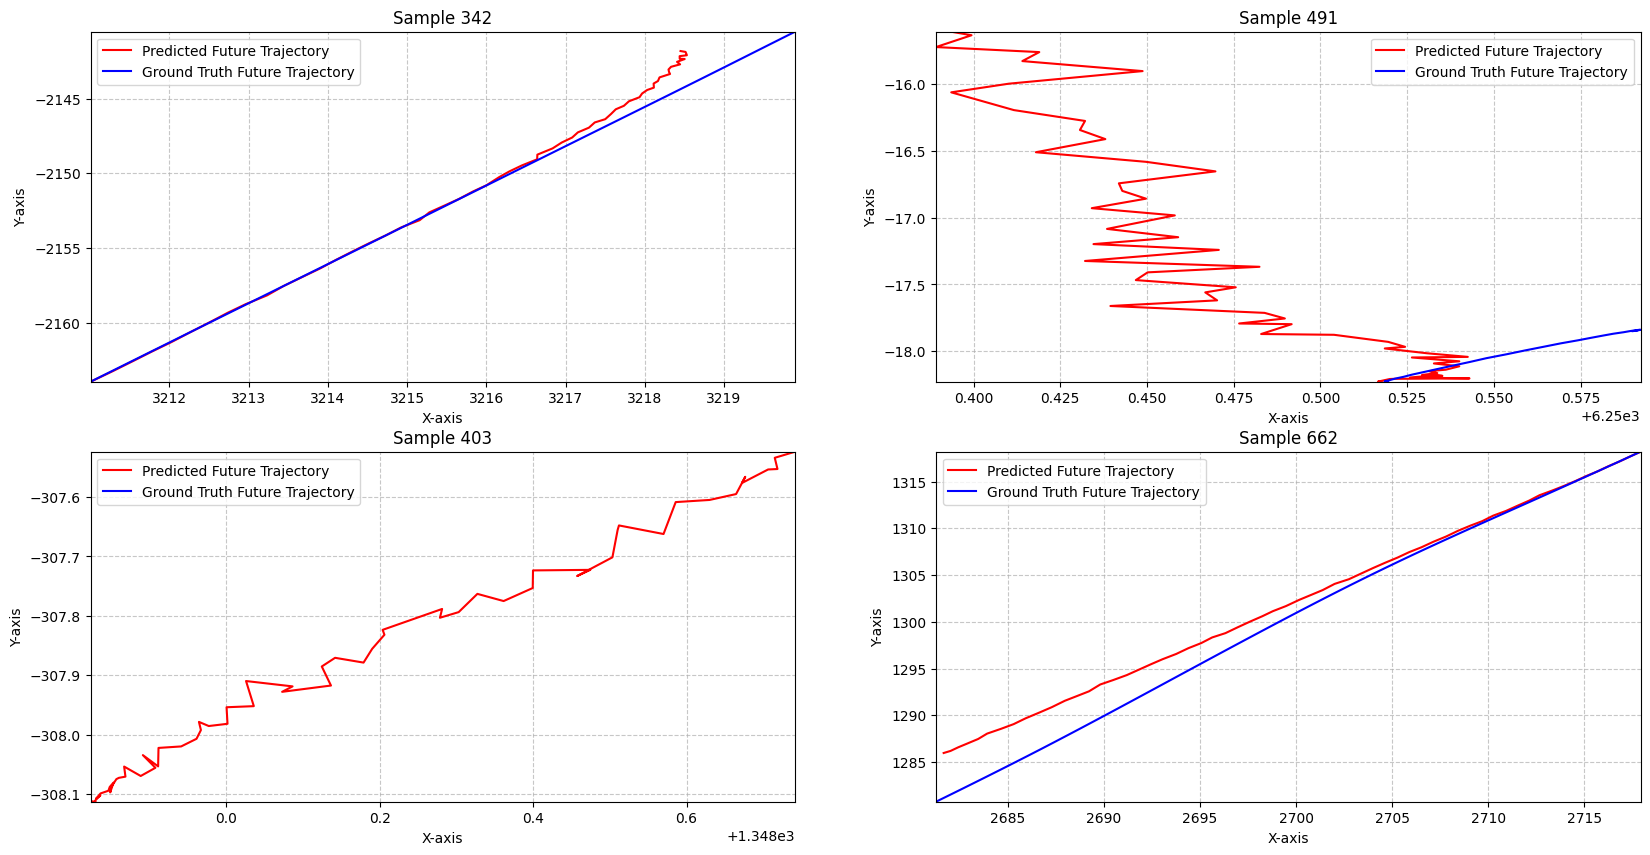

In [94]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [96]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
model = InteractionAwareLSTM().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B